In [7]:
import pandas as pd
from spark_session_manager import SparkSessionManager

In [8]:
spark = SparkSessionManager().get_spark_session()

## Load data

### Emotions

In [9]:
# emotions = pd.read_parquet("data/results/emotion-english-distilroberta-base-split_min.parquet")
emotions = spark.read.parquet("data/results/emotion-english-distilroberta-base-split_min.parquet")

emotions.head()

emotions.dtypes

[('video_id', 'string'),
 ('anger', 'double'),
 ('disgust', 'double'),
 ('fear', 'double'),
 ('joy', 'double'),
 ('neutral', 'double'),
 ('sadness', 'double'),
 ('surprise', 'double'),
 ('highest_confidence_emotion', 'string')]

In [4]:
# remove duplicates
emotions = emotions.dropDuplicates(subset=['video_id'])

In [20]:
emotions.head(20)

[Row(video_id='--SvHNpSvpk', anger=0.005676752887666225, disgust=0.005355197470635176, fear=0.006694482173770666, joy=0.07837428897619247, neutral=0.5112354159355164, sadness=0.2456246316432953, surprise=0.1470392346382141, highest_confidence_emotion='neutral'),
 Row(video_id='--gJDs10ShA', anger=0.9241438508033752, disgust=0.021352430805563927, fear=0.008110920898616314, joy=0.0019977663177996874, neutral=0.008527128957211971, sadness=0.0054464456625282764, surprise=0.030421489849686623, highest_confidence_emotion='anger'),
 Row(video_id='--hjHKgm67g', anger=0.21622449159622192, disgust=0.3774898648262024, fear=0.07863780111074448, joy=0.006555378437042236, neutral=0.20383568108081818, sadness=0.1043320968747139, surprise=0.012924706563353539, highest_confidence_emotion='disgust'),
 Row(video_id='-0PZSxZuAXQ', anger=0.011317762546241283, disgust=0.003688700497150421, fear=0.0034214965999126434, joy=0.23058640956878662, neutral=0.5751965641975403, sadness=0.06553573906421661, surprise=

### Engagement

In [16]:
# read parquet file
# engagement = pd.read_parquet("data/processed/engagement.parquet")
engagement = spark.read.parquet("data/processed/engagement.parquet")

# show the first 5 rows
engagement.head()

# show the schema
engagement.dtypes

[('id', 'bigint'),
 ('video_id', 'string'),
 ('likes', 'int'),
 ('dislikes', 'int'),
 ('comment_count', 'int'),
 ('view_count', 'int'),
 ('view_to_like_ratio', 'double'),
 ('like_to_comment_ratio', 'double'),
 ('engagement_rate', 'double'),
 ('comments_per_view', 'double'),
 ('average_views_per_day', 'double')]

In [17]:
# show first 50 rows, asc by video_id
engagement.orderBy("video_id").show(50)

+------+-----------+------+--------+-------------+----------+------------------+---------------------+------------------+--------------------+---------------------+
|    id|   video_id| likes|dislikes|comment_count|view_count|view_to_like_ratio|like_to_comment_ratio|   engagement_rate|   comments_per_view|average_views_per_day|
+------+-----------+------+--------+-------------+----------+------------------+---------------------+------------------+--------------------+---------------------+
| 60792|--14w5SOEUs|122830|     867|         9539|   1076217| 8.761841569649109|   12.876611804172345| 12.29947120329822|0.008863454117524625|            1076217.0|
| 60991|--14w5SOEUs|167034|    1755|        12998|   2146104|12.848306332842416|   12.850746268656716|  8.38878264986226|0.006056556439016935|            2146104.0|
| 61197|--14w5SOEUs|202153|    2518|        14721|   3317372|16.410204152300484|   13.732287208749405| 6.537524281268425|0.004437548758475082|            1658686.0|
| 61398|--

In [18]:
from pyspark.sql import functions as F

# join emotions and engagement metrics and data on column 'video_id', leave only one video_id column
# Join the dataframes on 'video_id'
wordcloud_df = engagement.join(emotions, on='video_id', how='inner')

wordcloud_df.orderBy("video_id").show(50)


+-----------+------+------+--------+-------------+----------+------------------+---------------------+------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+
|   video_id|    id| likes|dislikes|comment_count|view_count|view_to_like_ratio|like_to_comment_ratio|   engagement_rate|   comments_per_view|average_views_per_day|               anger|             disgust|                fear|                 joy|             neutral|             sadness|            surprise|highest_confidence_emotion|
+-----------+------+------+--------+-------------+----------+------------------+---------------------+------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------

## Descriptive Stats for Emotions

In [40]:
# import color palette
from style.emotions_palette import palette

# map the color palette to the emotions
emotion_dict = {
    'anger': 'red',
    'disgust': 'green',
    'fear': 'black',
    'joy': 'yellow',
    'neutral': 'grey',
    'sadness': 'blue',
    'surprise': 'orange'
}

# map the color palette to the emotions
emotions_palette = {k: palette[v] for k, v in emotion_dict.items()}

### Average views by emotions

In [42]:
# calculate average views by emotion

## group by emotion and calculate the average views
average_views_by_emotion = wordcloud_df.groupby('highest_confidence_emotion').agg({'view_count': 'mean'})

# change name of column 'highest_confidence_emotion' to 'emotion'
average_views_by_emotion = average_views_by_emotion.withColumnRenamed('highest_confidence_emotion', 'emotion')

In [43]:
average_views_by_emotion.show()

+--------+------------------+
| emotion|   avg(view_count)|
+--------+------------------+
|     joy| 2842972.042824706|
| neutral|2681463.9558491763|
|   anger| 2223559.851560428|
|    fear|3568719.0237273816|
|surprise|3316297.3522978346|
| sadness|1744728.3174656765|
| disgust|1944047.1853321576|
+--------+------------------+



In [51]:
from style.chart_defaults import *


In [54]:
# Assuming 'average_views_by_emotion' is your PySpark DataFrame
emotion_pd_df = average_views_by_emotion.toPandas()

import plotly.graph_objects as go

# Create a bar chart using Plotly
fig = go.Figure(go.Bar(
    x=emotion_pd_df['emotion'],  # Emotion names on the x-axis
    y=emotion_pd_df['avg(view_count)'],  # Average view counts on the y-axis
    marker=dict(
        color=emotion_pd_df['avg(view_count)'],  # Color the bars by average view counts
        colorscale='Viridis'  # Choose a colorscale that visually represents data well
    )
))

# Update the layout for a more customized look
fig.update_layout(
    title='Average YouTube View Count by Emotion',
    xaxis_title='Emotion',
    yaxis_title='Average View Count',
    font=dict(size=12)
)

# Show the figure
fig.show()

# save as html, use cdn
fig.write_html("charts/emotions/mean_views_by_emotion.html", include_plotlyjs='cdn')


### Emotion Distribution Across Categories

In [61]:
wordcloud_df.show()

+-----------+---+------+--------+-------------+----------+------------------+---------------------+------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+
|   video_id| id| likes|dislikes|comment_count|view_count|view_to_like_ratio|like_to_comment_ratio|   engagement_rate|   comments_per_view|average_views_per_day|               anger|             disgust|                fear|                 joy|             neutral|             sadness|            surprise|highest_confidence_emotion|
+-----------+---+------+--------+-------------+----------+------------------+---------------------+------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------

In [65]:
import plotly.express as px
from pyspark.sql import functions as F

# Print the schema to verify the structure
wordcloud_df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- id: long (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- view_to_like_ratio: double (nullable = true)
 |-- like_to_comment_ratio: double (nullable = true)
 |-- engagement_rate: double (nullable = true)
 |-- comments_per_view: double (nullable = true)
 |-- average_views_per_day: double (nullable = true)
 |-- anger: double (nullable = true)
 |-- disgust: double (nullable = true)
 |-- fear: double (nullable = true)
 |-- joy: double (nullable = true)
 |-- neutral: double (nullable = true)
 |-- sadness: double (nullable = true)
 |-- surprise: double (nullable = true)
 |-- highest_confidence_emotion: string (nullable = true)



In [67]:
emotion_category_distribution = wordcloud_df.groupby('highest_confidence_emotion').agg(F.count('video_id').alias('count'))

In [71]:
from style.emotions_palette import palette
# Create a stacked bar chart using the Pandas DataFrame
fig = px.bar(emotion_category_distribution,
             x='category',
             y='count',
                color='emotion',
                barmode='stack',
                title='Emotion Distribution Across Categories',
                color_discrete_map=palette
                )

fig.update_layout(template='plotly_dark')


# save as svg
fig.write_image(
    "charts/emotions/emotion_distribution_across_categories.svg", width=1200, height=800)

# save as html
fig.write_html(
    "charts/emotions/emotion_distribution_across_categories.html")

fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['highest_confidence_emotion', 'count'] but received: category

### Engagement Metrics by Emotion


### Average Engagement Metrics by Category

In [47]:
final_df.head()

,video_id,anger,disgust,fear,joy,neutral,sadness,surprise,highest_confidence_emotion,title,categoryTitle,view_to_like_ratio,like_to_comment_ratio,engagement_rate,comments_per_view,average_views_per_day,likes,dislikes,comment_count,view_count
0,3C66w5Z0ixs,0.502659,0.089732,0.012764,0.007059,0.16835,0.180872,0.038564,anger,I ASKED HER TO BE MY GIRLFRIEND...,People & Blogs,9.652879,4.443349,12.691088,0.023315,1514614.0,156908,5855,35313,1514614
1,3C66w5Z0ixs,0.502659,0.089732,0.012764,0.007059,0.16835,0.180872,0.038564,anger,I ASKED HER TO BE MY GIRLFRIEND...,People & Blogs,9.652879,4.443349,12.691088,0.023315,1514614.0,183592,9506,41374,3017834
2,3C66w5Z0ixs,0.502659,0.089732,0.012764,0.007059,0.16835,0.180872,0.038564,anger,I ASKED HER TO BE MY GIRLFRIEND...,People & Blogs,9.652879,4.443349,12.691088,0.023315,1514614.0,195344,10648,44555,3721729
3,3C66w5Z0ixs,0.502659,0.089732,0.012764,0.007059,0.16835,0.180872,0.038564,anger,I ASKED HER TO BE MY GIRLFRIEND...,People & Blogs,9.652879,4.443349,12.691088,0.023315,1514614.0,200215,10904,45461,3853404
4,3C66w5Z0ixs,0.502659,0.089732,0.012764,0.007059,0.16835,0.180872,0.038564,anger,I ASKED HER TO BE MY GIRLFRIEND...,People & Blogs,9.652879,4.443349,12.691088,0.023315,1514614.0,201808,10975,45574,3898795


In [48]:
# Calculate Average Engagement Metrics in PySpark


import numpy as np
import matplotlib.pyplot as plt
# !pip install palettable
from palettable import colorbrewer
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql.functions import avg

# Assuming df is a PySpark DataFrame with your data
metrics = final_df.groupby('categoryTitle').agg(
    avg('view_count').alias('average_views'),
    avg('like_count').alias('average_likes'),
    avg('dislike_count').alias('average_dislikes'),
    avg('comment_count').alias('average_comments'),
    avg('engagement_rate').alias('average_engagement_rate')
)


# Convert to Pandas DataFrame for visualization
metrics_pd = metrics.toPandas()

# ------------------------- normalize for radar chart ------------------------ #

scaler = MinMaxScaler()

metrics_normalized = pd.DataFrame(scaler.fit_transform(metrics_pd.iloc[:, 1:]),
                                  columns=metrics_pd.columns[1:],
                                  index=metrics_pd['categoryTitle'])

# Reset index to keep 'categoryId' as a column for plotting
metrics_normalized.reset_index(inplace=True)

# use color pallette from brewer

sequential_palette = colorbrewer.sequential.YlGnBu_9.hex_colors


# Plot Radar Chart


categories = list(metrics_normalized.columns[1:])
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for index, row in metrics_normalized.iterrows():
    data = metrics_normalized.iloc[index].drop('categoryId').tolist()
    data += data[:1]
    ax.plot(angles, data, linewidth=2,
            linestyle='solid', label=row['categoryId'])
    ax.fill(angles, data, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), categories)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# # add names of labels at the end of each line
# for i in range(len(metrics_normalized)):
#     ax.text(angles[-1], data[-1], metrics_normalized['categoryId'][i], fontsize=12, color=sequential_palette[i])

plt.show()


# save as svg


# save as svg
fig.write_image(
    "charts/eng_metrics/average_engagement_metrics.svg", width=1200, height=800)

TypeError: Column.__init__() missing 1 required positional argument: 'jc'

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume metrics_normalized_df has been normalized and contains categories as rows
# and metrics as columns, as per your previous data structure.

# Get unique categories
unique_categories = metrics_normalized['categoryId'].unique()

# Define the number of rows and columns for subplots
num_rows = int(len(unique_categories) ** 0.5)
num_cols = (len(unique_categories) + num_rows -
            1) // num_rows  # Ceiling division

# Create subplots, each subplot is a radar chart
fig = make_subplots(
    rows=num_rows, cols=num_cols,
    specs=[[{'type': 'polar'}] * num_cols] * num_rows,
    subplot_titles=unique_categories
)

# Plot each category in a separate radar chart
for i, category in enumerate(unique_categories):
    category_data = metrics_normalized[metrics_normalized['categoryId']
                                       == category].iloc[0]

    fig.add_trace(
        go.Scatterpolar(
            r=category_data[metrics].tolist() + [category_data[metrics[0]]],
            theta=metrics,
            fill='toself',
            name=category
        ),
        row=(i // num_cols) + 1,  # Row in subplot grid
        col=(i % num_cols) + 1    # Col in subplot grid
    )

# Update layout for all subplots
fig.update_layout(
    title='Average Engagement Metrics by Category',
    template='plotly_dark',
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=False
)

# hide avg_controversy_index etc labels outside radar
fig.update_polars(radialaxis=dict(visible=True, tickangle=45))


# save as svg
fig.write_image(
    "charts/eng_metrics/radar_chart_average_engagement_metrics.svg", width=1900, height=1200)

# save as html
fig.write_html(
    "charts/eng_metrics/radar_chart_average_engagement_metrics.html", auto_open=True)

In [ ]:
# comments rate = comments / views for category

### Correlation Heatmap

In [ ]:
# Convert to Pandas DataFrame (if not already in Pandas)
import plotly.figure_factory as ff
df_pd = wordcloud_df.select("view_count", "likes", "dislikes", "comment_count",
                                                            "comment_rate", "dislike_rate", "dislike_ratio", "controversy_index").toPandas()

# Calculate Correlation Matrix
corr_matrix = df_pd.corr()

# Plot Heatmap with Plotly

fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    annotation_text=corr_matrix.round(2).values,
    colorscale='Viridis',
    showscale=True
)

fig.update_layout(title_text='Correlation Heatmap of Engagement Metrics',
                  xaxis_title='Metrics',
                  yaxis_title='Metrics',
                  template='plotly_dark')

# save as svg
fig.write_image(
    "charts/eng_metrics/Correlation_Heatmap_of_Engagement_Metrics.svg", width=1200, height=800)

In [ ]:
import plotly.figure_factory as ff
import numpy as np

# Assuming df_pd is your Pandas DataFrame
corr_matrix = df_pd.corr()

# Mask to display only upper half
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heatmap
fig = ff.create_annotated_heatmap(
    z=corr_matrix.where(mask).values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    annotation_text=corr_matrix.where(mask).round(2).astype(str).values,
    colorscale='Viridis',
    showscale=True
)

# Update layout to include definitions
metric_definitions = """
<b>Definitions</b>:
<br>Comment Rate = comments / views || Dislike Rate = dislikes / view
<br>Dislike Ratio = dislikes / (likes + dislikes) || Controversy Index = comment rate * dislike ratio
"""

fig.update_layout(
    title='Correlation Heatmap of Engagement Metrics<br>',
    xaxis=dict(title='Metrics'),
    yaxis=dict(title='Metrics'),
    template='plotly_dark'
)

# inert annotations at the bottom

fig.add_annotation(
    text=metric_definitions,
    xref="paper", yref="paper",
    x=0.1, y=-0.1, showarrow=False,
    font=dict(size=14, color="white")
)

# save as svg
fig.write_image(
    "charts/eng_metrics/Correlation_Heatmap_of_Engagement_Metrics2.svg", width=1200, height=800)

In [ ]:
# correlation of emotions and engagement metrics

# Calculate Correlation Matrix
corr_matrix = wordcloud_df.select("view_count", "likes", "dislikes", "comment_count", "comment_rate", "dislike_rate", "dislike_ratio", "controversy_index") \
    .toPandas().corr()


corr_matrix

### Emotions per category

### create df for emotions

In [ ]:
# emotions per category
emotions_per_category = wordcloud_df.groupBy(
    'categoryId', 'emotion').count().orderBy('categoryId', 'emotion')

# convert to pandas
emotions_per_category_pd = emotions_per_category.toPandas()

# head
emotions_per_category_pd.head()

In [ ]:
# show whole dataframe, do not truncate
# import pandas as pd
# pd.set_option('display.max_rows', None)
# emotions_per_category_pd

In [ ]:
# chart emotions per category
# use stacked bar plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create a figure with subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=(
    "Emotions per Category", "Emotions per Category (Normalized)"))

# Create a bar plot for the absolute counts

for i, category in enumerate(emotions_per_category_pd['categoryId'].unique()):
    data = emotions_per_category_pd[emotions_per_category_pd['categoryId'] == category]
    fig.add_trace(go.Bar(x=data['emotion'],
                  y=data['count'], name=category), row=1, col=1)

# Create a bar plot for the normalized counts
for i, category in enumerate(emotions_per_category_pd['categoryId'].unique()):
    data = emotions_per_category_pd[emotions_per_category_pd['categoryId'] == category]
    fig.add_trace(go.Bar(x=data['emotion'], y=data['count'] /
                  data['count'].sum(), name=category), row=1, col=2)

### Sankey chart

In [ ]:
import pandas as pd
from pySankey.sankey import sankey
import matplotlib.pyplot as plt

# Assuming df_subset_pd is your DataFrame with 'emotion' and 'categoryId' columns ready for plotting

# Create a Sankey chart
sankey(df_subset_pd['emotion'],
       df_subset_pd['categoryId'], aspect=20, fontsize=10)

# Get current figure
fig = plt.gcf()

# Set the size of the figure in inches [width, height]
# Adjust these values as needed to avoid label collision
fig.set_size_inches(12, 12)

# Set the color of the background to black
fig.set_facecolor("black")

# set title "Emotions per Category (Sankey Diagram)"
plt.title("Emotions per Category (Sankey Diagram)", fontsize=14, color="white")

# set color of the labels to white
plt.rcParams['text.color'] = 'white'

# Save the figure to a file, adjust the dpi to increase the resolution
fig.savefig("charts/sankey-emotions-per-category.png", bbox_inches="tight", dpi=300)

# save plt to file 'html
# plt.savefig("charts/sankey-emotions-per-category.html", format='html')

In [ ]:
# Re-importing necessary library for the Sankey diagram
import plotly.graph_objects as go

# Assuming a simplified version of the provided data for demonstration purposes

# Correcting the data input issue and focusing on including colors for the emotions

# Simplified data structure for creating the Sankey diagram with colored emotions
category_ids = emotions_per_category_pd['categoryId'].astype(
    'category').cat.codes
emotion_ids = emotions_per_category_pd['emotion'].astype(
    'category').cat.codes + category_ids.max() + 1  # Offset by max category id
counts = emotions_per_category_pd['count']

# Unique categories and emotions for labeling
unique_categories = emotions_per_category_pd['categoryId'].astype(
    'category').cat.categories

unique_emotions = emotions_per_category_pd['emotion'].astype(
    'category').cat.categories

node_colors = [emotions_palette[emotion]
               if emotion in emotions_palette else 'grey' for emotion in unique_emotions]

# Creating the Sankey diagram with colors
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=list(unique_categories) + list(unique_emotions),
        # Default grey for categories, colored for emotions
        color=['grey']*len(unique_categories) + node_colors
    ),
    link=dict(
        source=category_ids,
        target=emotion_ids,
        value=counts
    ))])

fig.update_layout(
    title_text="YouTube Sentiment Analysis by Category and Emotion with Color", font_size=12)

# save as html, use cdn
fig.write_html("charts/sankey.html", include_plotlyjs='cdn')

## proportions of emotions within each YouTube category

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming emotions_per_category_pd is your DataFrame

# Pivot the DataFrame to get a matrix where categories are rows, emotions are columns, and values are counts
pivot_df = emotions_per_category_pd.pivot(
    index='categoryId', columns='emotion', values='count').fillna(0)

# Normalize the counts by row to get proportions
proportions = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Plot a 100% stacked bar chart
proportions.plot(kind='bar', stacked=True, figsize=(10, 7))

# Configure the plot with titles, labels, etc.
plt.title('Proportion of Emotions per YouTube Category')
plt.xlabel('Category')
plt.ylabel('Proportion of Emotions')
plt.legend(title='Emotion')
plt.tight_layout()

# change color of legend
plt.legend(title='Emotion', title_fontsize='12',
           fontsize='12', facecolor='black', edgecolor='black', loc='center left', bbox_to_anchor=(1, 0.5))
# Show the plot
plt.show()

In [ ]:
# Pivot the DataFrame to get a matrix where categories are rows, emotions are columns, and values are counts
# pivot_df = emotions_per_category_pd.pivot(index='categoryId', columns='emotion', values='count').fillna(0)

# Normalize the counts by row to get proportions
proportions = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Create a list of traces for the stacked bar chart, one for each emotion
traces = []

# Pivot the DataFrame to have categories as rows and emotions as columns, filling NaNs with 0
category_emotion_counts = emotions_per_category_pd.pivot_table(
    index='categoryId',
    columns='emotion',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Calculate the proportions
category_emotion_proportions = category_emotion_counts.div(
    category_emotion_counts.sum(axis=1), axis=0)

# Create the plotly figure with one trace for each emotion column
fig = go.Figure()

for emotion in category_emotion_proportions.columns:
    fig.add_trace(go.Bar(
        name=emotion,
        x=category_emotion_proportions.index,
        y=category_emotion_proportions[emotion],
        hoverinfo='none'  # Disable default hoverinfo
    ))

# Update the layout of the figure to stack the bars and adjust the y-axis to show percentage
fig.update_layout(
    barmode='stack',
    title='Proportion of Emotions per YouTube Category',
    xaxis_title='Category',
    yaxis=dict(
        title='Proportion',
        tickformat=',.0%'
    ),
    hoverlabel=dict(  # Customize hover label
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
    legend_title_text='Emotion'
)

# Define the custom hovertemplate with HTML
# {emotion} in {category}: {y:.2%} <extra></extra>
hovertemplate = "<b>%{y:.2%}</b> of <b>%{x}</b> emits <b>%{fullData.name}</b><extra></extra>"

# Apply custom hovertemplate to each trace
for trace in fig.data:
    trace.hovertemplate = hovertemplate

# change colors of the bars using the emotions_palette
for i, emotion in enumerate(category_emotion_proportions.columns):
    fig.data[i].marker.color = emotions_palette[emotion]

# Save the figure to an HTML file
fig.write_html("charts/stacked_bar.html", include_plotlyjs='cdn')

## Engagement metrics by emotion 

### Stewise regression

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize a list to keep track of variables added and their R²
selected_variables = []
current_r2 = -float("inf")
improvement = True

# List all potential predictors
potential_predictors = ["comment_rate", "like_rate", "dislike_rate", "dislike_ratio", "controversy_index"]

while improvement:
    improvement = False
    best_r2_for_step = current_r2
    
    for predictor in potential_predictors:
        # Temporary model with the current selected variables plus the new potential predictor
        assembler = VectorAssembler(inputCols=selected_variables + [predictor], outputCol="features")
        
        # Fit and evaluate the model
        lr = LinearRegression(featuresCol="features", labelCol="view_count")
        pipeline = Pipeline(stages=[assembler, lr])
        model = pipeline.fit(train_data)  # Assuming train_data is already defined
        predictions = model.transform(test_data)  # Assuming test_data is already defined
        
        evaluator = RegressionEvaluator(labelCol="view_count", predictionCol="prediction", metricName="r2")
        r2 = evaluator.evaluate(predictions)
        
        # Check if this model is the best so far
        if r2 > best_r2_for_step:
            best_r2_for_step = r2
            best_predictor = predictor
            improvement = True
            
    # If there was an improvement, update the list of selected variables and the current best R²
    if improvement:
        selected_variables.append(best_predictor)
        current_r2 = best_r2_for_step
        potential_predictors.remove(best_predictor)
        print(f"Added {best_predictor}. New R² is {best_r2_for_step}.")


In [ ]:
# print the selected variables
print("Selected variables:", selected_variables)

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Assuming df_subset is your DataFrame that includes 'categoryId', 'emotion', and engagement metrics

# List of engagement metrics to include as features
feature_cols = ["comment_rate", "like_rate", "dislike_rate", "dislike_ratio", "controversy_index"]

# Initialize an evaluator for R2
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="view_count", metricName="r2")

# Retrieve unique categories and emotions
categories = wordcloud_df.select("categoryId").distinct().rdd.flatMap(lambda x: x).collect()
emotions = wordcloud_df.select("emotion").distinct().rdd.flatMap(lambda x: x).collect()

results = []

for category in categories:
    for emotion in emotions:
        # Filter the DataFrame for the current category and emotion
        df_filtered = wordcloud_df.filter((wordcloud_df.categoryId == category) & (wordcloud_df.emotion == emotion))
        
        # Check if the filtered DataFrame is not empty
        if df_filtered.count() > 0:
            assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
            lr = LinearRegression(featuresCol="features", labelCol="view_count")
            
            # Define the pipeline
            pipeline = Pipeline(stages=[assembler, lr])
            
            # Split the data
            train_data, test_data = df_filtered.randomSplit([0.7, 0.3], seed=42)
            
            # Fit the model
            model = pipeline.fit(train_data)
            
            # Make predictions
            predictions = model.transform(test_data)
            
            # Evaluate the model
            r2 = evaluator.evaluate(predictions)
            
            # Store the results
            results.append(((category, emotion), r2))
        else:
            results.append(((category, emotion), None))

# Display the results
for result in results:
    print(f"Category: {result[0][0]}, Emotion: {result[0][1]}, R2: {result[1]}")


## Word cloud

In [31]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

In [32]:
# load data - parquet
metadata = spark.read.parquet("data/processed/metadata.parquet")

In [33]:
metadata.show()

+-----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-----------------+----------------+--------------------+
|   video_id|               title|         publishedAt|           channelId|        channelTitle|categoryId|      thumbnail_link|comments_disabled|ratings_disabled|         description|
+-----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-----------------+----------------+--------------------+
|-1AAhZwrS3U|GOLDBRIDGE! Manch...|2022-10-02T15:41:05Z|UCMmVPVb0BwSIOWVe...|    The United Stand|        17|https://i.ytimg.c...|            false|           false|Man City 6-3 Man ...|
|-1wcilQ58hI|Starship Flight Test|2023-04-20T14:08:39Z|UCtI0Hodo5o5dUb67...|              SpaceX|        28|https://i.ytimg.c...|            false|           false|Starship gave us ...|
|-2yCVay_eqo|Wilbur and Ranboo...|2022-05-06T19:02:21Z|UC1n_PfsVqxllCc

In [34]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gr00stl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Stemming titles

In [35]:
# Step 1: Select the 'title' column and collect the data
titles = metadata.select("title").rdd.flatMap(lambda x: x).collect()

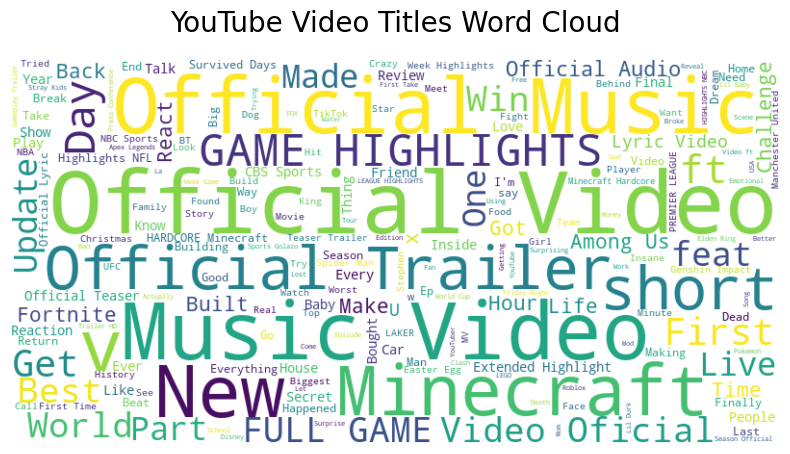

In [59]:
# Step 2: Define a function to create a word cloud
def create_word_cloud(titles, use_stemming=False, chart_title='YouTube Video Titles Word Cloud'):
    text = ' '.join(titles)  # Combine all titles into a single string

    # Optional: Apply stemming
    if use_stemming:
        stemmer = PorterStemmer()
        tokens = text.split()
        text = ' '.join(stemmer.stem(token) for token in tokens)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=set(stopwords.words('english'))).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(chart_title, fontsize=20, pad=20, color='black')

    plt.show()

# Step 3: Create the word cloud (change use_stemming to True if you decide to use stemming)
create_word_cloud(titles, use_stemming=False)

In [37]:
# check if values in video_id are unique
emotions.select("video_id").distinct().count() == emotions.count()

True

In [38]:
# join emotions and metadata on video_id
wordcloud_df = emotions.join(metadata, on='video_id', how='inner')

In [39]:
wordcloud_df.show()

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-----------------+----------------+--------------------+
|   video_id|               anger|             disgust|                fear|                 joy|             neutral|             sadness|            surprise|highest_confidence_emotion|               title|         publishedAt|           channelId|        channelTitle|categoryId|      thumbnail_link|comments_disabled|ratings_disabled|         description|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+---------

In [40]:
# stem words in the title column, output it to a new column 'title_stemmed'
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk.stem import PorterStemmer
import nltk
import string

# Download necessary NLTK resources
nltk.download('punkt')

# Step 2: Define a Python function for stemming
def stem_title(title):

    if not title:
        return ""
    try:    
        # remove stopwords
        stop_words = set(stopwords.words('english'))
        ## remove punctuation
        title = title.translate(str.maketrans('', '', string.punctuation))
        # stemmer
        stemmer = PorterStemmer()
        tokens = nltk.word_tokenize(title)  # Tokenize the title
        stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Stem each token
        # return tuple of stemmed tokens (joined with ,)
        return ', '.join(stemmed_tokens)
    
    except Exception as e:
        return "Error: " + str(e)

[nltk_data] Downloading package punkt to /home/gr00stl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
# use udf to apply the function to the title column and output it to a new column 'title_stemmed'
stem_title_udf = udf(stem_title, StringType())
wordcloud_df = wordcloud_df.withColumn("title_stemmed", stem_title_udf("title"))
wordcloud_df.show()

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-----------------+----------------+--------------------+--------------------+
|   video_id|               anger|             disgust|                fear|                 joy|             neutral|             sadness|            surprise|highest_confidence_emotion|               title|         publishedAt|           channelId|        channelTitle|categoryId|      thumbnail_link|comments_disabled|ratings_disabled|         description|       title_stemmed|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+---------

In [42]:
# Example title for testing
test_title = "GOLDBRIDGE! Manchester United 1-6 Manchester City | Match Reaction"
print(stem_title(test_title))  # This should print the stemmed version of the test title


goldbridg, manchest, unit, 16, manchest, citi, match, reaction


### Lemmatization

In [43]:
from pyspark.sql import functions as F
from pyspark.sql.session import SparkSession
from pyspark.sql.types import ArrayType

# Start Spark session
spark = SparkSession.builder.appName("LemmatizationOptimization").getOrCreate()

# Broadcasting stopwords
stopwords_list = nltk.corpus.stopwords.words('english')
broadcast_stopwords = spark.sparkContext.broadcast(stopwords_list)

# Using native Spark functions for text processing
wordcloud_df = wordcloud_df.withColumn("clean_title", F.lower(F.col("title")))
wordcloud_df = wordcloud_df.withColumn("clean_title", F.regexp_replace(F.col("clean_title"), '[^\w\s]', ''))  # Remove punctuation
wordcloud_df = wordcloud_df.withColumn("words", F.split(F.col("clean_title"), " "))

# Filtering stopwords using a native function
def filter_stopwords(words_list):
    return [word for word in words_list if word not in broadcast_stopwords.value]

filter_stopwords_udf = F.udf(filter_stopwords, ArrayType(StringType()))
wordcloud_df = wordcloud_df.withColumn("filtered_words", filter_stopwords_udf(F.col("words")))

# At this point, add more native transformations or MLlib feature transformers if needed

# Show results
wordcloud_df.select("title", "filtered_words").show(truncate=False)

# Remember to unpersist data if you have used cache
wordcloud_df.unpersist()

24/04/24 22:07:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+
|title                                                                                     |filtered_words                                                                                   |
+------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+
|GOLDBRIDGE! Manchester City 6-3 Manchester United | Match Reaction                        |[goldbridge, manchester, city, 63, manchester, united, , match, reaction]                        |
|Starship Flight Test                                                                      |[starship, flight, test]                                                                         |
|Wilbur and Ranboo Scam the Origins SMP      

DataFrame[video_id: string, anger: double, disgust: double, fear: double, joy: double, neutral: double, sadness: double, surprise: double, highest_confidence_emotion: string, title: string, publishedAt: string, channelId: string, channelTitle: string, categoryId: string, thumbnail_link: string, comments_disabled: boolean, ratings_disabled: boolean, description: string, title_stemmed: string, clean_title: string, words: array<string>, filtered_words: array<string>]

In [44]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

spark = sparknlp.start()  # This will start a Spark session with Spark NLP


24/04/24 22:07:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [45]:
import sparknlp

# Start Spark session for Spark NLP
spark = sparknlp.start()
print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)


Spark NLP version:  5.3.3
Apache Spark version:  3.5.1


In [46]:
# Load DataFrame (Assuming DataFrame is loaded into 'df' with a column named 'title')
# df = spark.read.option("header", "true").csv("your_data.csv")

# Document Assembler - Converts the input text into Document type required by Spark NLP
document_assembler = DocumentAssembler() \
    .setInputCol("title") \
    .setOutputCol("document")

# Tokenizer - Splits the text into words
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Normalizer - Cleans the text, removing non-alphanumeric characters
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True) \
    .setCleanupPatterns(["[^\\w\d\s]"])  # remove punctuations and numbers, keep alphanumeric

# Lemmatizer - Converts words into their base or root form
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(["normalized"]) \
    .setOutputCol("lemma")

# Finisher - Transforms the data into a format that can be handled by Spark MLlib
finisher = Finisher() \
    .setInputCols(["lemma"]) \
    .setOutputCols(["lemmatized_text"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)

# Define the pipeline
pipeline = Pipeline().setStages([
    document_assembler,
    tokenizer,
    normalizer,
    lemmatizer,
    finisher
])

# Transform the DataFrame
model = pipeline.fit(wordcloud_df)
result = model.transform(wordcloud_df)

# Show the results
result.select("title", "lemmatized_text").show(truncate=False)


lemma_antbnc download started this may take some time.


Approximate size to download 907.6 KB
[OK!]
+------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------+
|title                                                                                     |lemmatized_text                                                                                |
+------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------+
|GOLDBRIDGE! Manchester City 6-3 Manchester United | Match Reaction                        |[goldbridge, manchester, city, 63, manchester, united, match, reaction]                        |
|Starship Flight Test                                                                      |[starship, flight, test]                                                                       |
|Wilbur and

In [47]:
result.select(
    "title", 
    "title_stemmed",
    "lemmatized_text"
    ).show(truncate=False)

+------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------+
|title                                                                                     |title_stemmed                                                                              |lemmatized_text                                                                                |
+------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------+
|GOLDBRIDGE! Manchester City 6-3 Manchester United | Match Reaction                        |goldbridg, manchest, citi, 63, manchest, unit, match, reaction   

### Wordcloud for all videos

+---------------+-----+
|lemmatized_word|count|
+---------------+-----+
|            the|10920|
|              i| 7568|
|       official| 5509|
|             in| 4936|
|          video| 4707|
|              a| 4532|
|             to| 4529|
|             be| 3881|
|             of| 3585|
|             vs| 2761|
|      highlight| 2464|
|             on| 2346|
|            and| 2345|
|        trailer| 2245|
|             we| 2243|
|            you| 2218|
|           with| 2098|
|      minecraft| 1912|
|           game| 1880|
|            for| 1870|
+---------------+-----+
only showing top 20 rows



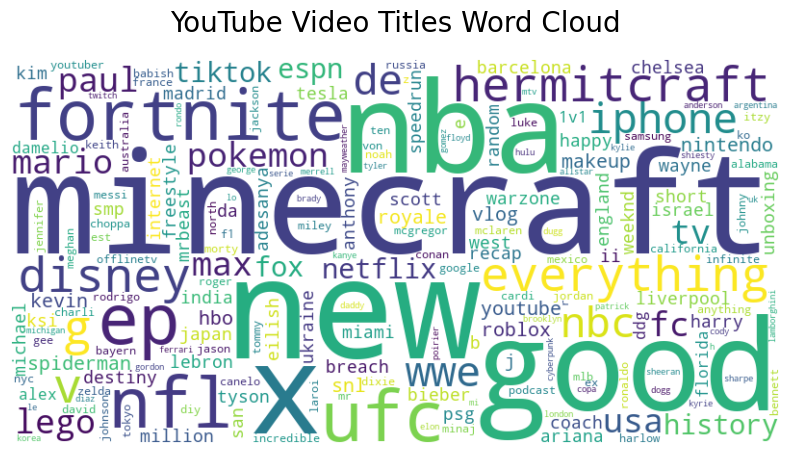

In [64]:
# build wordcloud for lemmatized text
from pyspark.sql.functions import explode

# Explode the lemmatized text array into separate rows
lemma_df = result.withColumn("lemmatized_word", explode("lemmatized_text"))

# Group by lemmatized words and count the occurrences
lemma_df = lemma_df.groupBy("lemmatized_word").count().orderBy("count", ascending=False)

# Show the DataFrame
lemma_df.show()

# Convert the DataFrame to Pandas for word cloud visualization
lemma_pd = lemma_df.toPandas()

# Create a word cloud -> use create_word_cloud(titles, use_stemming=False)
create_word_cloud(lemma_pd['lemmatized_word'], use_stemming=False)

In [49]:
lemma_df.show()

+---------------+-----+
|lemmatized_word|count|
+---------------+-----+
|            the|10920|
|              i| 7568|
|       official| 5509|
|             in| 4936|
|          video| 4707|
|              a| 4532|
|             to| 4529|
|             be| 3881|
|             of| 3585|
|             vs| 2761|
|      highlight| 2464|
|             on| 2346|
|            and| 2345|
|        trailer| 2245|
|             we| 2243|
|            you| 2218|
|           with| 2098|
|      minecraft| 1912|
|           game| 1880|
|            for| 1870|
+---------------+-----+
only showing top 20 rows



In [51]:
wordcloud_df.show()

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-----------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   video_id|               anger|             disgust|                fear|                 joy|             neutral|             sadness|            surprise|highest_confidence_emotion|               title|         publishedAt|           channelId|        channelTitle|categoryId|      thumbnail_link|comments_disabled|ratings_disabled|         description|       title_stemmed|         clean_title|               words|      filtered_words|
+-----------+--------------------+--------------------+--------------------+--------------------+---------------

### Wordcloud for specific emotion

In [61]:
# build function to build wordcloud for input of emotion based on lemmatized text

## subset for specific emotion
def create_word_cloud_emotion(emotion, use_stemming=False):
    # Filter the DataFrame for the specified emotion
    emotion_df = wordcloud_df.filter(wordcloud_df.highest_confidence_emotion == emotion)
    
    # Select the 'title' column and collect the data
    titles = emotion_df.select("title").rdd.flatMap(lambda x: x).collect()
    
    # Create the word cloud
    create_word_cloud(titles, use_stemming, f"Word Cloud for '{emotion}' Emotion")


# Example usage
# create_word_cloud_emotion("anger", use_stemming=False) 

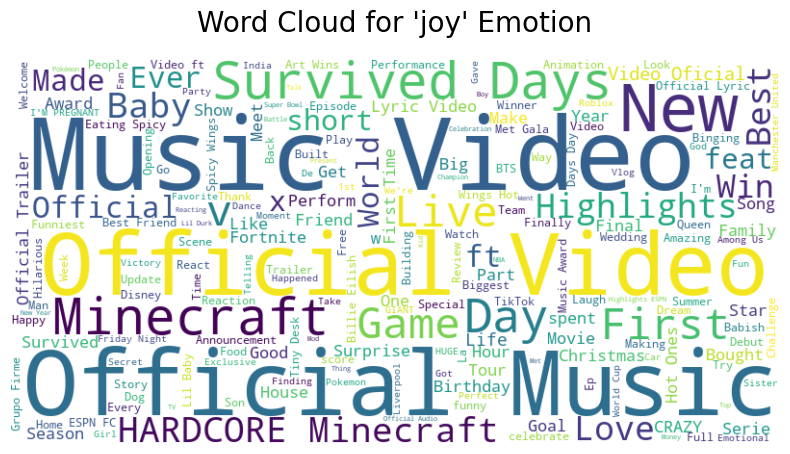

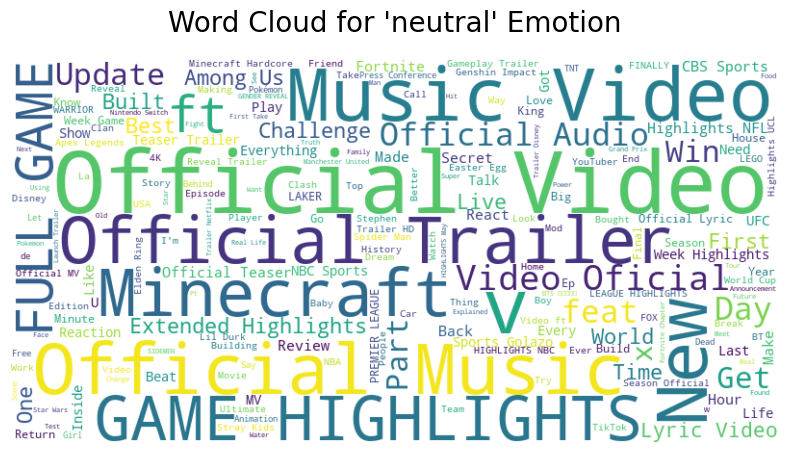

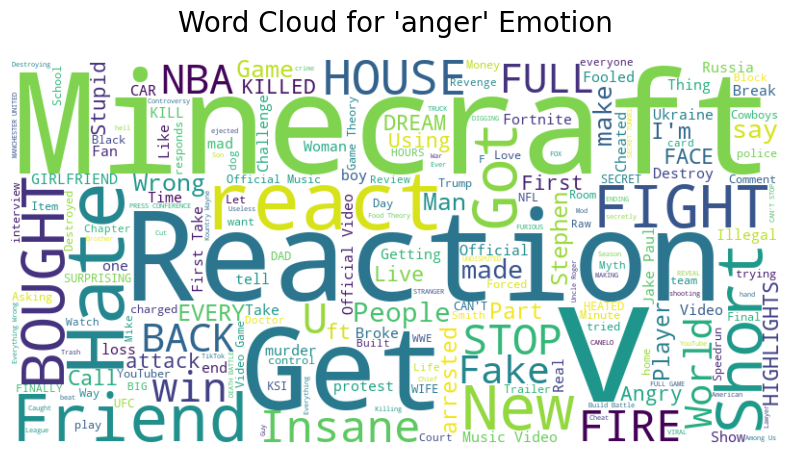

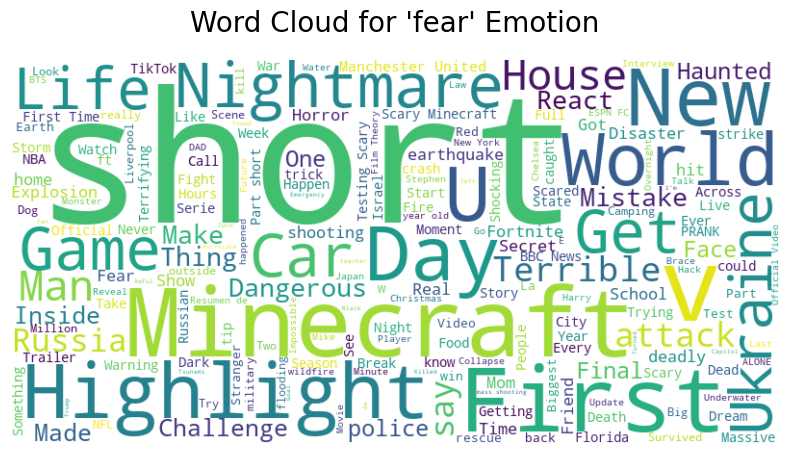

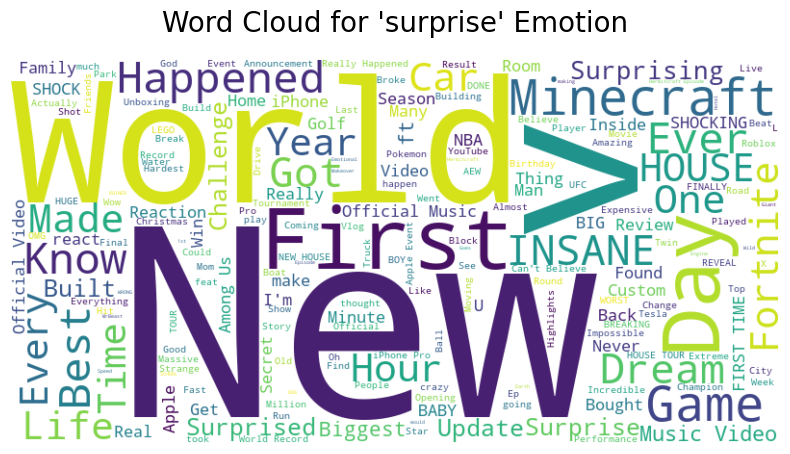

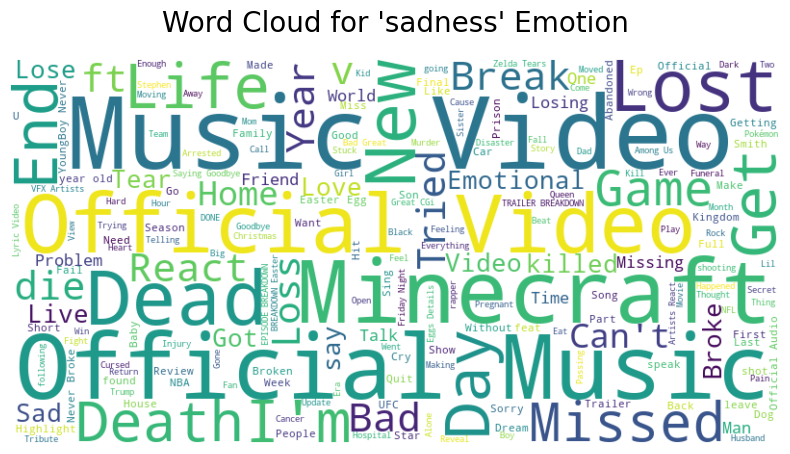

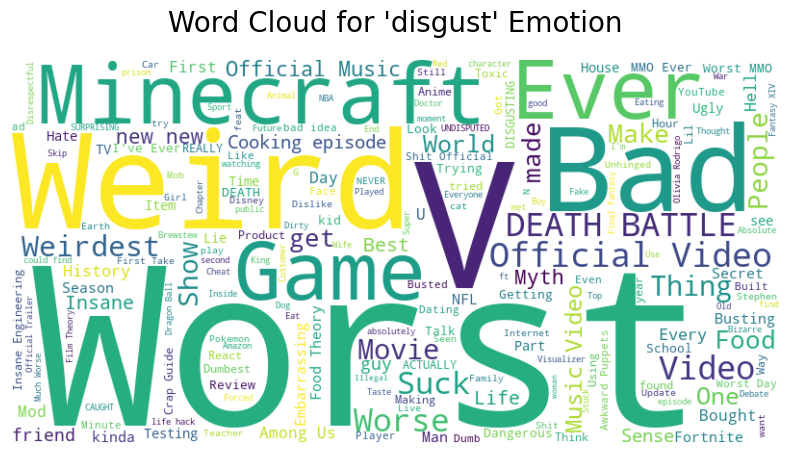

In [63]:
for emotion in wordcloud_df.select("highest_confidence_emotion").distinct().rdd.flatMap(lambda x: x).collect():
    create_word_cloud_emotion(emotion, use_stemming=False)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import string

# Make sure NLTK resources are available on all nodes
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


def get_wordnet_pos(treebank_tag):
    """Converts treebank tags to wordnet tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# apply lemmatization to the title column


[nltk_data] Downloading package punkt to /home/gr00stl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gr00stl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gr00stl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
